In [1]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

print('All modules imported.')

All modules imported.


# 1 Reload the preprocessed data

In [2]:
# 1 Reload the preprocessed data

pickle_file = './pre-traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2 AlexNet Architecture

In [4]:
def AlexNet(x, KEEP_PROB, LAMBDA): 
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    reg_loss = tf.zeros(1)
        
    # Conv 1: Input = 32x32x3. Output = 28x28x9.
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 3, 9), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(9))
    conv1 = tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x9. Output = 14x14x9.
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
       
    # Conv 2: Input = 14x14x9. Output = 12x12x32.
    # Convolutional. 
    conv2_w = tf.Variable(tf.truncated_normal((3, 3, 9, 32), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(pool1, conv2_w, [1, 1, 1, 1], 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 12x12x32. Output = 6x6x32.
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Conv 3: Input = 6x6x32. Output = 6x6x48.
    # Convolutional. 
    conv3_w = tf.Variable(tf.truncated_normal((3, 3, 32, 48), mu, sigma))
    conv3_b = tf.Variable(tf.zeros(48))
    conv3 = tf.nn.conv2d(pool2, conv3_w, [1, 1, 1, 1], 'SAME') + conv3_b
    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Conv 4: Input = 6x6x48. Output = 6x6x64.
    # Convolutional. 
    conv4_w = tf.Variable(tf.truncated_normal((3, 3, 48, 64), mu, sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b
    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Conv 5: Input = 6x6x64. Output = 6x6x96.
    # Convolutional. 
    conv5_w = tf.Variable(tf.truncated_normal((3, 3, 64, 96), mu, sigma))
    conv5_b = tf.Variable(tf.zeros(96))
    conv5 = tf.nn.conv2d(conv4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b
    # Activation.
    conv5 = tf.nn.relu(conv5)
    
    # Pooling. Input = 6x6x96. Output = 3x3x96.
    pool3 = tf.nn.max_pool(conv5, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
      
    # Flatten. Input = 3x3x96. Output = 864.
    flat = flatten(pool3)   
    
    # full 1: Input = 864. Output = 400.
    # Fully Connected. 
    full1_w = tf.Variable(tf.truncated_normal((864, 400), mu, sigma))
    full1_b = tf.Variable(tf.zeros(400))
    full1 = tf.matmul(flat, full1_w) + full1_b
    # Activation.
    full1 = tf.nn.relu(full1) 
    # Dropout
    full1 = tf.nn.dropout(full1, KEEP_PROB)
    
    # full 2: Input = 400. Output = 160.
    # Fully Connected. 
    full2_w = tf.Variable(tf.truncated_normal((400, 160), mu, sigma))
    full2_b = tf.Variable(tf.zeros(160))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, KEEP_PROB)
    
    # output : Fully Connected. Input = 160. Output = 43.
    full3_w = tf.Variable(tf.truncated_normal((160, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b

    if LAMBDA != 0:
        reg_loss = tf.nn.l2_loss(conv1_w) + tf.nn.l2_loss(conv2_w) + tf.nn.l2_loss(conv3_w) + tf.nn.l2_loss(conv4_w) + tf.nn.l2_loss(conv5_w) + tf.nn.l2_loss(full1_w) + tf.nn.l2_loss(full2_w) + tf.nn.l2_loss(full3_w)
    
    return logits, reg_loss

# 3 Training

## 3.1 Strategy
- #### learning rate decay: tf.train.exponential_decay(INITIAL_LEARNING_RATE, global_step=global_step, decay_steps=150, decay_rate=0.95) is used for decay learing rate, global_step increment after each step only when you give it to minimize(loss_op, global_step=global_step) as the global_step paramenter.

In [15]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())
LAMBDA = tf.placeholder_with_default(0.0, shape=())

# Hyperparameters
LEARNING_RATE = 5e-4
EPOCHS = 30
BATCH_SIZE = 128

# parameters for learning rate decay
# global_step = tf.Variable(0, trainable=False)
# LEARNING_RATE = tf.train.exponential_decay(1e-2, global_step=global_step, decay_steps=180, decay_rate=0.96)

# Train method
logits, reg_loss = AlexNet(x, keep_prob, LAMBDA)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
# batch gradient descent optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
# Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
# train_op = optimizer.minimize(loss_op, global_step=global_step)
train_op = optimizer.minimize(loss_op)

## 3.2 Evaluation

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_op, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 3.3 Train the Model
#### A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.
#### LAMBDA controls the regulization degree, if LAMBDA is too large, the model will be underfitting; if LAMBDA too small, the model will be overfitting.

In [19]:
%%time
# 2min 7s
train_accuracy = []
valid_accuracy = []
learning_rates = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_train_acc = 0
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):# 34799 / BATCH_SIZE = 271
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_acc = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, LAMBDA: 1e-5})
#             _, train_acc, lr = sess.run([train_op, accuracy_op, LEARNING_RATE], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_train_acc += (train_acc * len(batch_x))
        train_accuracy.append(total_train_acc / num_examples)
        valid_acc = evaluate(X_valid, y_valid)
        valid_accuracy.append(valid_acc)
        print("Valid Accuracy = {:.3f}".format(valid_acc))
                
    saver.save(sess, './model/alexnet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Valid Accuracy = 0.505
EPOCH 2 : Valid Accuracy = 0.792
EPOCH 3 : Valid Accuracy = 0.859
EPOCH 4 : Valid Accuracy = 0.918
EPOCH 5 : Valid Accuracy = 0.925
EPOCH 6 : Valid Accuracy = 0.934
EPOCH 7 : Valid Accuracy = 0.934
EPOCH 8 : Valid Accuracy = 0.947
EPOCH 9 : Valid Accuracy = 0.939
EPOCH 10 : Valid Accuracy = 0.946
EPOCH 11 : Valid Accuracy = 0.946
EPOCH 12 : Valid Accuracy = 0.951
EPOCH 13 : Valid Accuracy = 0.950
EPOCH 14 : Valid Accuracy = 0.954
EPOCH 15 : Valid Accuracy = 0.954
EPOCH 16 : Valid Accuracy = 0.954
EPOCH 17 : Valid Accuracy = 0.949
EPOCH 18 : Valid Accuracy = 0.949
EPOCH 19 : Valid Accuracy = 0.948
EPOCH 20 : Valid Accuracy = 0.958
EPOCH 21 : Valid Accuracy = 0.956
EPOCH 22 : Valid Accuracy = 0.964
EPOCH 23 : Valid Accuracy = 0.961
EPOCH 24 : Valid Accuracy = 0.956
EPOCH 25 : Valid Accuracy = 0.954
EPOCH 26 : Valid Accuracy = 0.956
EPOCH 27 : Valid Accuracy = 0.958
EPOCH 28 : Valid Accuracy = 0.955
EPOCH 29 : Valid Accuracy = 0.957
EPOCH 30 : 

#### Plot the accuracy of training and validation operation

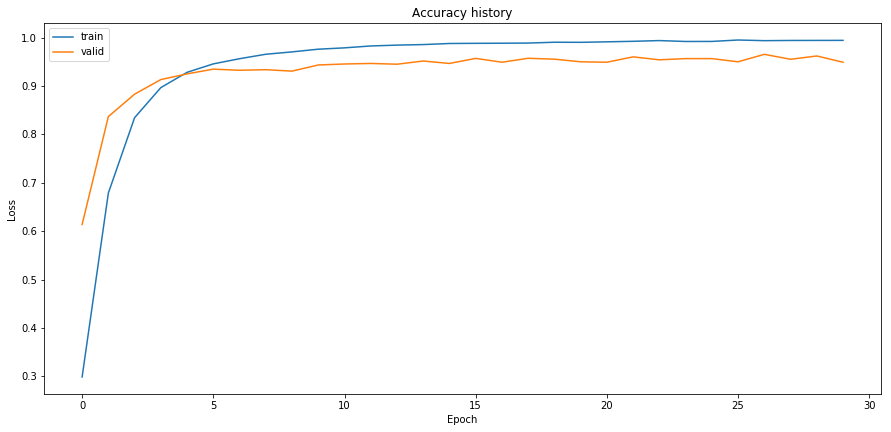

In [18]:
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 15)
plt.legend()
plt.show()

#### A good choice of learning rate decay parameters will plot a curvature with the bottom near to zero.

No handles with labels found to put in legend.


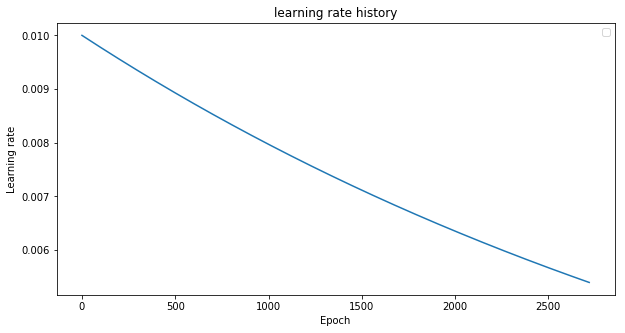

In [26]:
plt.plot(learning_rates)
plt.title('learning rate history')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.show()

# 4 Testing

## 4.1 Test the model on testing dataset

INFO:tensorflow:Restoring parameters from ./model/alexnet.ckpt


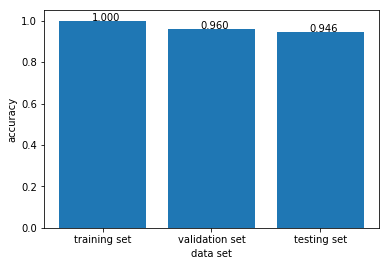

In [20]:
with tf.Session() as sess:
    saver.restore(sess, './model/alexnet.ckpt')
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

## 4.2 Test the Model on New Images
To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type. You may find signnames.csv useful as it contains mappings from the class id (integer) to the actual sign name.

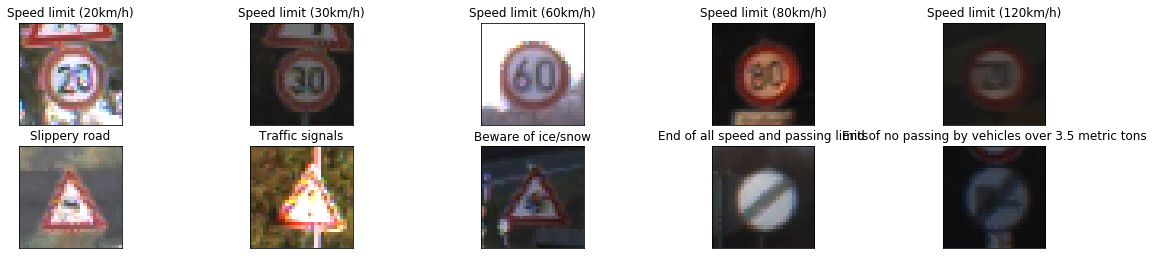

In [13]:
gt_images = []
gt_labels = []

with open('./test_images/labels.csv') as f:
    gt_labels = [row[7] for row in csv.reader(f)]
# print(gt_labels)

for i in range(1, 11):
    img = Image.open('./test_images/' + str(i) +'.ppm')
    img.save('./test_images/' + str(i) +'.jpg')
    gt_images.append(plt.imread('./test_images/' + str(i) +'.ppm'))
# print(gt_images)

plt.figure(figsize=(20, 20))
for i in range(len(gt_images)):
    plt.subplot(9, 5, i + 1), plt.imshow(gt_images[i]), plt.title(signnames[int(gt_labels[i])])
    plt.xticks([]), plt.yticks([])
    
gt_images = np.array(gt_images)
gt_labels = np.array(gt_labels)
    
# Normalization
gt_images = gt_images.astype(np.float32) / 128. - 1.

Predict the Sign Type for Each Image

In [14]:
with tf.Session() as sess:
    saver.restore(sess, './model/lenet.ckpt')
    test_accuracy = evaluate(gt_images, gt_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))   
    logits_value = sess.run(logits, feed_dict={x: gt_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from ./model/lenet.ckpt
Test Accuracy = 1.000
Predict the Sign Type for Each Image
[ 0  1  3  5  8 23 26 30 32 42]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web
For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

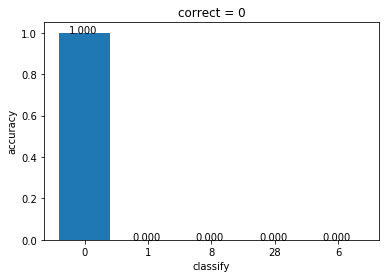

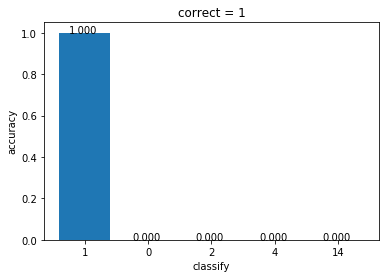

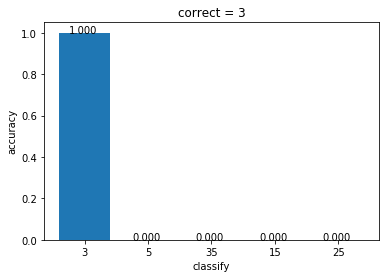

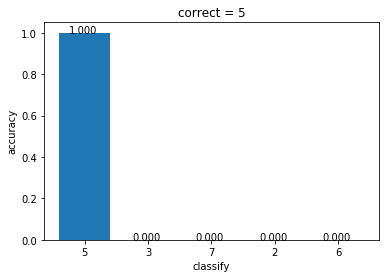

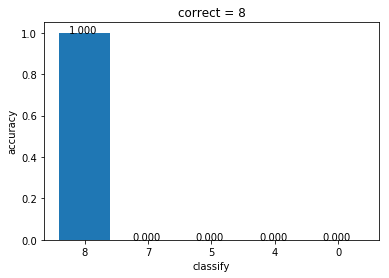

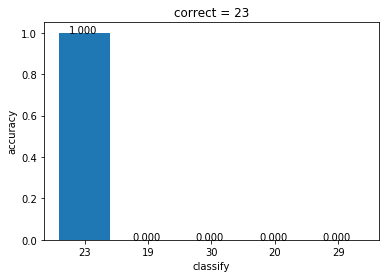

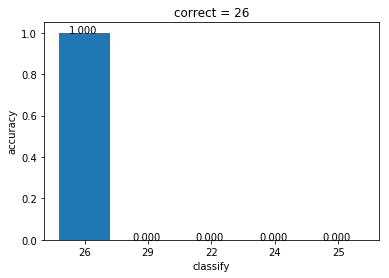

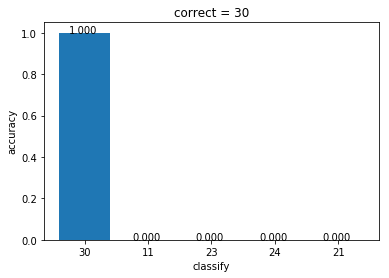

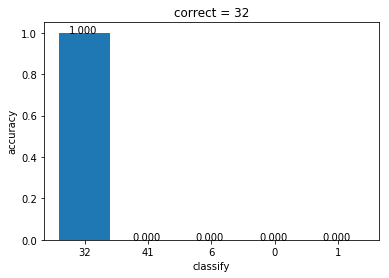

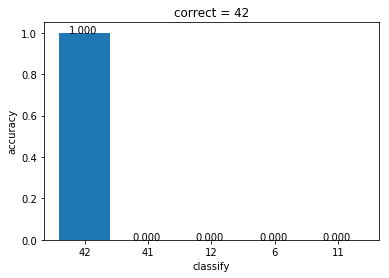

In [15]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

def plt_bar(values, indicex, answer):
    plt.bar(range(5), values)
    plt.xlabel('classify')
    plt.ylabel('accuracy')
    plt.xticks(range(5), indicex)
    plt.title("correct = "+answer)
    for x_,y_ in zip(range(5), values):
        plt.text(x_ - 0.25, y_, '%.3f'%y_)
    plt.show()

for i in range(10):
    plt_bar(top5.values[i], top5.indices[i], gt_labels[i])